In [4]:
pip install numpy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import random

def visualize_hetero_graph(graph):
    G = nx.Graph()

    # 添加用户节点
    for i in range(graph['user'].x.shape[0]):
        G.add_node(f'U{i}', bipartite=0)

    # 添加地点节点
    for i in range(graph['place'].x.shape[0]):
        G.add_node(f'P{i}', bipartite=1)

    # 添加边
    edge_index = graph['user', 'place'].edge_index
    for i in range(edge_index.shape[1]):
        user = f'U{edge_index[0, i].item()}'
        place = f'P{edge_index[1, i].item()}'
        G.add_edge(user, place)

    edge_attr = graph['user', 'place'].edge_attr
    weights = []
    for i in range(edge_index.shape[1]):
        weights.append(edge_attr[i].item())
    max_weight = max(weights)
    min_weight = min(weights)
    normalized_weights = [(w - min_weight) / (max_weight - min_weight) * 4 + 1 for w in weights]

    # 设置布局
    pos = nx.spring_layout(G, iterations=10, k=0.1)

    # 绘制节点
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if node.startswith('U')], 
                           node_color='lightblue', node_size=300, label='Users')
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if node.startswith('P')], 
                           node_color='lightgreen', node_size=300, label='Places')

    # 绘制边
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=normalized_weights)

    # 添加标签
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title("Heterogeneous Graph: Users and Places")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    # plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig4.jpg", dpi=600, bbox_inches='tight')
    plt.show()

## 构建异质图

In [1]:
import pandas as pd
import torch
from collections import defaultdict
from torch_geometric.data import HeteroData
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import numpy as np
import warnings
import geohash2
import random
from gensim.models import Word2Vec
import numpy as np

warnings.filterwarnings('ignore')

# 读取数据
df = pd.read_csv('D:/研究生/03Phd/segregation/shanghai/shanghai_weibo.csv', encoding='gbk')

# 对类别特征进行编码，但保存原始标签
le = LabelEncoder()
categorical_cols = ['city', 'gender', 'age_label', 'SES', 'category']
original_labels = {}
for col in categorical_cols:
    original_labels[col] = df[col].copy()
    df[col] = le.fit_transform(df[col])
    original_labels[f'{col}_decoder'] = dict(zip(range(len(le.classes_)), le.classes_))

# 过滤掉出现次数小于2次的地点
place_counts = df['place'].value_counts()
valid_places = place_counts[place_counts > 2].index
df = df[df['place'].isin(valid_places)]

def geohash_encode(lat, lng, precision=6):
    return geohash2.encode(lat, lng, precision)

def create_geohash_embeddings(geohashes, embedding_dim=8):
    sequences = [[char for char in geohash] for geohash in geohashes]
    model = Word2Vec(sequences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    embeddings = np.array([np.mean([model.wv[char] for char in geohash], axis=0) for geohash in geohashes])
    return embeddings

def calculate_relative_position(lat, lng, center_lat=31.2304, center_lng=121.4737):
    """计算相对于上海市中心的位置"""
    return lat - center_lat, lng - center_lng

def build_hetero_graph(df):
    data = HeteroData()

    # 用户节点特征处理
    user_features = df.groupby('user_id')[['gender', 'age_label', 'SES']].first().reset_index()
    
    # One-hot 编码
    onehot_encoder = OneHotEncoder(sparse_output=False)
    user_onehot = onehot_encoder.fit_transform(user_features[['gender', 'age_label', 'SES']])
    data['user'].x = torch.tensor(user_onehot, dtype=torch.float)
    user_mapping = {id: i for i, id in enumerate(user_features['user_id'])}
    # 添加 node_id 属性
    data['user'].node_id = torch.arange(len(user_mapping), dtype=torch.long)

    # 地点节点特征处理
    place_features = df.groupby('place')[['lng', 'lat', 'category']].first().reset_index()
    category_onehot = onehot_encoder.fit_transform(place_features[['category']])
    place_features['geohash'] = place_features.apply(lambda row: geohash_encode(row['lat'], row['lng']), axis=1)
    geohash_embeddings = create_geohash_embeddings(place_features['geohash'])
    place_features['rel_lat'], place_features['rel_lng'] = zip(*place_features.apply(
                    lambda row: calculate_relative_position(row['lat'], row['lng']), axis=1
                                                                            ))
    # 组合经度、纬度和 category 的 one-hot 编码
    place_features_combined = np.hstack([
        place_features[['rel_lat', 'rel_lng']].values, 
        category_onehot,
        geohash_embeddings  # 添加地理哈希嵌入
    ])
    data['place'].x = torch.tensor(place_features_combined, dtype=torch.float)
    place_mapping = {place: i for i, place in enumerate(place_features['place'])}
    # 添加 node_id 属性
    data['place'].node_id = torch.arange(len(place_mapping), dtype=torch.long)

    # 计算边的权重（访问次数）
    edge_weights = df.groupby(['user_id', 'place']).size().reset_index(name='weight')
    edge_weights['user_index'] = edge_weights['user_id'].map(user_mapping)
    edge_weights['place_index'] = edge_weights['place'].map(place_mapping)
    scaler = MinMaxScaler()
    edge_weights['normalized_weight'] = scaler.fit_transform(edge_weights[['weight']])

    # 用户-地点边
    user_indices = edge_weights['user_index'].tolist()
    place_indices = edge_weights['place_index'].tolist()
    data['user', 'place'].edge_index = torch.tensor([user_indices, place_indices], dtype=torch.long)
    data['user', 'place'].edge_attr = torch.tensor(edge_weights['normalized_weight'].values, dtype=torch.float)

    # 添加用户-用户边
    user_places = defaultdict(set)
    for _, row in df.iterrows():
        user_places[row['user_id']].add(row['place'])

    user_user_edges = []
    min_common_places = 3  # 最小共同地点数阈值

    for user1 in user_places:
        for user2 in user_places:
            if user1 < user2:  # 避免重复边
                common_places = user_places[user1].intersection(user_places[user2])
                if len(common_places) >= min_common_places:
                    user_user_edges.append((user_mapping[user1], user_mapping[user2], len(common_places)))

    if user_user_edges:
        user_user_edges = torch.tensor(user_user_edges, dtype=torch.long)
        data['user', 'to', 'user'].edge_index = user_user_edges[:, :2].t()
        # data['user', 'to', 'user'].edge_attr = user_user_edges[:, 2].float()

    return data, user_features, place_features

graph, user_features, place_features = build_hetero_graph(df)

# visualize_hetero_graph(graph)

In [2]:
###visual samples
# visualize_hetero_graph(graph)

In [3]:
graph

HeteroData(
  user={
    x=[9986, 9],
    node_id=[9986],
  },
  place={
    x=[3768, 26],
    node_id=[3768],
  },
  (user, to, place)={
    edge_index=[2, 29667],
    edge_attr=[29667],
  },
  (user, to, user)={ edge_index=[2, 2554] }
)

In [4]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit
from typing import Union, Tuple, List
import torch_geometric.transforms as T


### 自定义一个函数，可以设置seed，确保每次实验结果的一致性
class SeededRandomLinkSplit(RandomLinkSplit):
    def __init__(self, edge_types: Union[List[str], str], *args, seed: int = None, **kwargs):
        super().__init__(edge_types=edge_types, *args, **kwargs)
        self.seed = seed

    def forward(
        self,
        data: HeteroData,
    ) -> Tuple[HeteroData, HeteroData, HeteroData]:
        if self.seed is not None:
            rng_state = torch.get_rng_state()
            if torch.cuda.is_available():
                cuda_rng_state = torch.cuda.get_rng_state()

            torch.manual_seed(self.seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(self.seed)

        result = super().forward(data)

        if self.seed is not None:
            torch.set_rng_state(rng_state)
            if torch.cuda.is_available():
                torch.cuda.set_rng_state(cuda_rng_state)

        return result

##################输入图
to_undirected = T.ToUndirected()
graph = to_undirected(graph)

# 使用 SeededRandomLinkSplit 而不是 RandomLinkSplit
transform = SeededRandomLinkSplit(
    num_val=0.1,  # 10% 的边用于验证
    num_test=0.1,  # 10% 的边用于测试
    is_undirected=True,
    disjoint_train_ratio=0.3,  # 70% 的边用于消息传递，30% 的边用于监督
    neg_sampling_ratio=2.0,  # 固定负样本的比例为 2:1
    add_negative_train_samples=True,  # 在训练集中添加负样本
    edge_types=[("user", "to", "place")],  # 注意这里需要是一个列表
    rev_edge_types=[("place", "rev_to", "user")],  # 注意这里需要是一个列表
    seed=42  # 设置随机种子
)

train_data, val_data, test_data = transform(graph)
train_data

HeteroData(
  user={
    x=[9986, 9],
    node_id=[9986],
  },
  place={
    x=[3768, 26],
    node_id=[3768],
  },
  (user, to, place)={
    edge_index=[2, 16615],
    edge_attr=[16615],
    edge_label=[21360],
    edge_label_index=[2, 21360],
  },
  (user, to, user)={ edge_index=[2, 5108] },
  (place, rev_to, user)={
    edge_index=[2, 16615],
    edge_attr=[16615],
  }
)

## GNN模块

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch_sparse
from torch import Tensor
from torch_geometric.nn import (SAGEConv, GATConv, HeteroConv, HGTConv, RGCNConv, HANConv, GraphConv, to_hetero, GCNConv)
from torch_geometric.data import HeteroData

################################################################
# Encoder classes
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.2):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.2):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, add_self_loops=False, dropout=dropout)
        self.conv2 = GATConv(hidden_channels, hidden_channels, add_self_loops=False, dropout=dropout)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class Hetero(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, metadata, dropout=0.2):
        super().__init__()
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        })
        self.conv2 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        })
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(self.dropout(x)) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads, num_layers, metadata, dropout=0.2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, metadata, num_heads)
            self.convs.append(conv)
        self.lins = torch.nn.ModuleDict({
            node_type: torch.nn.Linear(hidden_channels, hidden_channels)
            for node_type in metadata[0]
        })
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(self.dropout(x)) for key, x in x_dict.items()}
        return {node_type: self.lins[node_type](x) for node_type, x in x_dict.items()}

class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, num_relations, dropout=0.2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = RGCNConv(in_channels, hidden_channels, num_relations)
            self.convs.append(conv)
        self.lin = torch.nn.Linear(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_type):
        for conv in self.convs:
            x = conv(x, edge_index, edge_type)
            x = F.relu(self.dropout(x))
        return self.lin(x)

class HAN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, metadata, dropout=0.2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HANConv(in_channels, hidden_channels, metadata, heads=4, dropout=dropout)
            self.convs.append(conv)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(self.dropout(x)) for key, x in x_dict.items()}
        return {key: self.lin(x) for key, x in x_dict.items()}

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x
    
class GCN2(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.5, sample_size=100000, seed=42):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.sample_size = sample_size
        self.seed = seed

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # 设置随机种子
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        np.random.seed(self.seed)

        # 对边进行采样
        if edge_index.size(1) > self.sample_size:
            perm = torch.randperm(edge_index.size(1))[:self.sample_size]
            edge_index = edge_index[:, perm]  
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x
    
################################################################
# Decoder class
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.classifier = torch.nn.Linear(hidden_channels * 2, 1)

    def forward(self, user_x, place_x, edge_index):
        edge_feat = torch.cat([user_x[edge_index[0]], place_x[edge_index[1]]], dim=-1)
        return self.classifier(edge_feat).squeeze(-1)
    
class MLPEdgeDecoder(nn.Module):
    def __init__(self, hidden_channels, mlp_hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels * 2, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, 1)
        )

    def forward(self, user_x, place_x, edge_index):
        edge_feat = torch.cat([user_x[edge_index[0]], place_x[edge_index[1]]], dim=-1)
        return self.mlp(edge_feat).squeeze(-1)

###############################################################
# Complete Model
class Model(torch.nn.Module):
    def __init__(self, graph: HeteroData, hidden_channels, out_channels, 
                 gnn_type='SAGE', num_layers=2, seed=42, consider_user_user=False):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.seed = seed
        self.consider_user_user = consider_user_user

        # 设置全局随机种子
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        np.random.seed(self.seed)

        self.node_embeddings = torch.nn.ModuleDict()
        for node_type in graph.node_types:
            num_nodes = graph[node_type].num_nodes
            self.node_embeddings[node_type] = torch.nn.Embedding(num_nodes, hidden_channels)
        
        self.node_transforms = torch.nn.ModuleDict()
        for node_type in graph.node_types:
            if hasattr(graph[node_type], 'x'):
                in_channels = graph[node_type].x.size(1)
                self.node_transforms[node_type] = torch.nn.Linear(in_channels, hidden_channels)
        
        # 用于user-user关系的GCN
        if self.consider_user_user:
            self.user_encoder = GCN2(hidden_channels, hidden_channels, sample_size=100000, seed=self.seed)

        if gnn_type == 'SAGE':
            self.encoder = to_hetero(SAGE(hidden_channels, hidden_channels), graph.metadata())
        elif gnn_type == 'GAT':
            self.encoder = to_hetero(GAT(hidden_channels, hidden_channels), graph.metadata())
        elif gnn_type == 'Hetero':
            self.encoder = Hetero(hidden_channels, hidden_channels, graph.metadata())
        elif gnn_type == 'HGT':
            self.encoder = HGT(hidden_channels, num_heads=4, num_layers=num_layers, metadata=graph.metadata())
        elif gnn_type == 'RGCN':
            num_relations = len(graph.edge_types)
            self.encoder = RGCN(hidden_channels, hidden_channels, num_layers, num_relations)
        elif gnn_type == 'HAN':
            self.encoder = HAN(hidden_channels, hidden_channels, out_channels, num_layers, graph.metadata())
        elif gnn_type == 'GCN':
            self.encoder = to_hetero(GCN(hidden_channels, hidden_channels), graph.metadata())

        self.decoder = MLPEdgeDecoder(hidden_channels)

    def forward(self, graph: HeteroData) -> Tensor:
        # 设置随机种子
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        np.random.seed(self.seed)
        
        # 初始化节点特征
        x_dict = {}
        for node_type in graph.node_types:
            x = self.node_embeddings[node_type](graph[node_type].node_id)
            if node_type in self.node_transforms:
                x = x + self.node_transforms[node_type](graph[node_type].x)
            x_dict[node_type] = x

        # 使用采样的GCN编码器处理用户特征（如果考虑user-user关系）
        if self.consider_user_user:
            user_edge_index = graph['user', 'to', 'user'].edge_index
            x_dict['user'] = self.user_encoder(x_dict['user'], user_edge_index)

        # 使用选定的编码器处理整个异构图
        if isinstance(self.encoder, RGCN):
            edge_index, edge_type = self.prepare_edges(graph)
            x = torch.cat([x_dict[node_type] for node_type in graph.node_types])
            x = self.encoder(x, edge_index, edge_type)
            
            # 将结果分配回各个节点类型
            start = 0
            for node_type in graph.node_types:
                num_nodes = graph[node_type].num_nodes
                x_dict[node_type] = x[start:start + num_nodes]
                start += num_nodes
        else:
            x_dict = self.encoder(x_dict, graph.edge_index_dict)

        # 预测user-place连接
        user_x = x_dict['user']
        place_x = x_dict['place']
        edge_index = graph['user', 'to', 'place'].edge_label_index

        return self.decoder(user_x, place_x, edge_index)

    def prepare_edges(self, graph: HeteroData):
        edge_index_list = []
        edge_type_list = []
        for i, (src, edge_type, dst) in enumerate(graph.edge_types):
            edge_index = graph[src, edge_type, dst].edge_index
            edge_index_list.append(edge_index)
            edge_type_list.append(torch.full((edge_index.size(1),), i, dtype=torch.long))
        edge_index = torch.cat(edge_index_list, dim=1)
        edge_type = torch.cat(edge_type_list)
        return edge_index, edge_type

## 训练模块

In [10]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import roc_curve, auc
import numpy as np

def train_model(model, train_data, optimizer, criterion, num_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    train_data = train_data.to(device)
    
    losses = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data)
        target = train_data["user", "to", "place"].edge_label
        loss = criterion(pred, target.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    return losses, model

# gnn_types = ['SAGE', 'GAT', 'Hetero', 'HGT', 'RGCN', 'HAN']
gnn_types = ['HGT']
all_losses = {}
all_models = {}

for gnn_type in gnn_types:
    print(f"Training {gnn_type} model...")
    model = Model(graph=train_data, hidden_channels=64, out_channels=64, gnn_type=gnn_type, consider_user_user=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()
    losses, trained_model = train_model(model, train_data, optimizer, criterion, 200)
    all_losses[gnn_type] = losses
    all_models[gnn_type] = trained_model

Training HGT model...
Epoch: 010, Loss: 0.6531
Epoch: 020, Loss: 0.6310
Epoch: 030, Loss: 0.6158
Epoch: 040, Loss: 0.6013
Epoch: 050, Loss: 0.5812
Epoch: 060, Loss: 0.5260
Epoch: 070, Loss: 0.4731
Epoch: 080, Loss: 0.4402
Epoch: 090, Loss: 0.4213
Epoch: 100, Loss: 0.4034
Epoch: 110, Loss: 0.3854
Epoch: 120, Loss: 0.3673
Epoch: 130, Loss: 0.3503
Epoch: 140, Loss: 0.3297
Epoch: 150, Loss: 0.3100
Epoch: 160, Loss: 0.2918
Epoch: 170, Loss: 0.2762
Epoch: 180, Loss: 0.2577
Epoch: 190, Loss: 0.2411
Epoch: 200, Loss: 0.2400


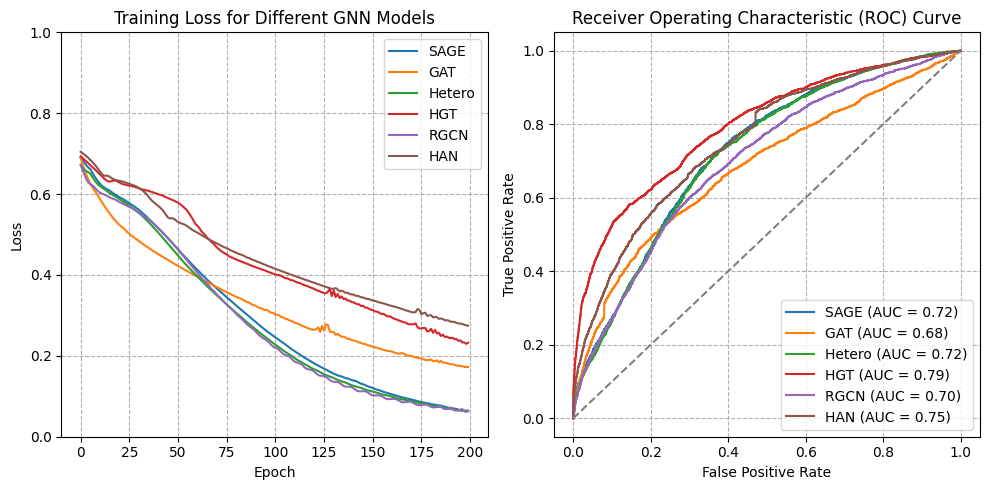

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def smooth_curve(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

window_size = 10  # 移动平均窗口大小，可以根据需要调整
smooth_models = ['Hetero', 'SAGE']  # 指定需要平滑的模型名称

for gnn_type, losses in all_losses.items():
    if gnn_type in smooth_models:
        losses_series = pd.Series(losses)
        smoothed_losses = losses_series.rolling(window=window_size, center=True, min_periods=1).mean()
        plt.plot(smoothed_losses, label=f'{gnn_type}')
    else:
        plt.plot(losses, label=gnn_type)

plt.ylim(0, 1)  # 您可以根据需要调整这里的值
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Different GNN Models')
plt.legend()
plt.grid(True, linestyle="--")


# 计算和绘制ROC曲线
plt.subplot(1, 2, 2)
for gnn_type, model in all_models.items():
    model.eval()
    with torch.no_grad():
        pred = model(test_data)
        target = test_data["user", "to", "place"].edge_label
        pred_np = pred.cpu().numpy()
        target_np = target.cpu().numpy()
        
        fpr, tpr, _ = roc_curve(target_np, pred_np)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{gnn_type} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle="--")

plt.tight_layout()
# plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig3.jpg", dpi=600, bbox_inches='tight')
plt.show()

## 模型准确度

In [11]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import torch
import numpy as np

def test(model, data):
    model.eval()
    with torch.no_grad():
        pred = model(data)
        pred = pred.cpu().numpy()
        target = data["user", "to", "place"].edge_label.cpu().numpy()
        pred_binary = (pred > 0).astype(int)
        auc = roc_auc_score(target, pred)
        acc = accuracy_score(target, pred_binary)
        f1 = f1_score(target, pred_binary)
        print(f"AUC: {auc:.4f}")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        return auc, acc, f1

model.eval()
print("Test set results:")
test(model, val_data)

Test set results:
AUC: 0.7911
Accuracy: 0.6997
F1 Score: 0.6181


(0.7910962361017583, 0.6997077995055069, 0.6180674671240709)

##  生成负样本

In [12]:
import torch
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling
from collections import Counter
import random
import numpy as np

def add_negative_samples_hetero(graph, neg_sampling_ratio=1.0, min_edges_per_node=3, seed=None):
    """
    向异构图中添加负样本边，并创建edge_label_index。
    确保每个节点至少有指定数量的边，优先为边数少的节点添加边。
    只为指定的边类型添加负样本。
    
    参数:
    graph (torch_geometric.data.HeteroData): 输入异构图
    neg_sampling_ratio (float): 负样本与正样本的比例，默认为1.0
    min_edges_per_node (int): 每个节点最少应有的边数，默认为3
    seed (int): 随机种子，用于确保结果可重复
    
    返回:
    torch_geometric.data.HeteroData: 添加了负样本的新图
    """
    # 设置随机种子
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

    new_graph = graph.clone()
    
    for edge_type in graph.edge_types:
        # 只为 (user, to, place) 边类型添加负样本
        if edge_type != ('user', 'to', 'place'):
            continue
        
        pos_edge_index = graph[edge_type].edge_index
        src_node_type, _, dst_node_type = edge_type
        
        # 计算每个节点的边数
        src_edge_count = Counter(pos_edge_index[0].tolist())
        dst_edge_count = Counter(pos_edge_index[1].tolist())
        
        num_neg_samples = int(pos_edge_index.size(1) * neg_sampling_ratio)
        
        # 找出需要额外边的节点
        src_nodes_need_edges = [node for node, count in src_edge_count.items() if count < min_edges_per_node]
        dst_nodes_need_edges = [node for node, count in dst_edge_count.items() if count < min_edges_per_node]
        
        # 为需要额外边的节点创建负边
        additional_neg_edges = []
        for src in src_nodes_need_edges:
            for dst in range(graph[dst_node_type].num_nodes):
                if src_edge_count[src] >= min_edges_per_node:
                    break
                if dst not in dst_edge_count or dst_edge_count[dst] < min_edges_per_node:
                    if not ((pos_edge_index[0] == src) & (pos_edge_index[1] == dst)).any():
                        additional_neg_edges.append([src, dst])
                        src_edge_count[src] += 1
                        dst_edge_count[dst] += 1
        
        for dst in dst_nodes_need_edges:
            for src in range(graph[src_node_type].num_nodes):
                if dst_edge_count[dst] >= min_edges_per_node:
                    break
                if src not in src_edge_count or src_edge_count[src] < min_edges_per_node:
                    if not ((pos_edge_index[0] == src) & (pos_edge_index[1] == dst)).any():
                        additional_neg_edges.append([src, dst])
                        src_edge_count[src] += 1
                        dst_edge_count[dst] += 1
        
        # 如果还需要更多负边，使用负采样生成
        remaining_neg_samples = max(0, num_neg_samples - len(additional_neg_edges))
        if remaining_neg_samples > 0:
            remaining_neg_edge_index = negative_sampling(
                edge_index=pos_edge_index,
                num_nodes=(graph[src_node_type].num_nodes, graph[dst_node_type].num_nodes),
                num_neg_samples=remaining_neg_samples,
            )
            additional_neg_edges.extend(remaining_neg_edge_index.t().tolist())
        
        neg_edge_index = torch.tensor(additional_neg_edges).t()
        
        # 创建edge_label_index
        edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        
        # 创建边标签：正边为1，负边为0
        edge_label = torch.cat([
            torch.ones(pos_edge_index.size(1)),
            torch.zeros(neg_edge_index.size(1))
        ], dim=0)
        
        # 更新新图的边、边标签和edge_label_index
        new_graph[edge_type].edge_index = pos_edge_index  # 保持原始edge_index不变
        new_graph[edge_type].edge_label = edge_label
        new_graph[edge_type].edge_label_index = edge_label_index
    
    return new_graph

In [13]:
# 使用优化后的函数，并设置随机种子
seed = 42  # 你可以选择任何整数作为种子
graph_samples = add_negative_samples_hetero(graph, neg_sampling_ratio=2.0, min_edges_per_node=10, seed=seed)
graph_samples

HeteroData(
  user={
    x=[9986, 9],
    node_id=[9986],
  },
  place={
    x=[3768, 26],
    node_id=[3768],
  },
  (user, to, place)={
    edge_index=[2, 29667],
    edge_attr=[29667],
    edge_label=[89001],
    edge_label_index=[2, 89001],
  },
  (user, to, user)={ edge_index=[2, 5108] },
  (place, rev_to, user)={
    edge_index=[2, 29667],
    edge_attr=[29667],
  }
)

## 隔离计算

In [14]:
import tqdm
import torch
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler

def calculate_gini(probs):
    """计算基尼系数"""
    sorted_probs = np.sort(probs)
    index = np.arange(1, len(probs) + 1)
    n = len(probs)
    return (np.sum((2 * index - n - 1) * sorted_probs)) / (n * np.sum(probs))

from scipy import stats

def composite_integration_index(df, integration_col, entropy_col, gini_col):
    scaler = MinMaxScaler()
    df['normalized_integration'] = scaler.fit_transform(df[[integration_col]])
    df['normalized_entropy'] = scaler.fit_transform(df[[entropy_col]])
    df['normalized_gini'] = scaler.fit_transform(df[[gini_col]])
    df['reversed_gini'] = 1 - df['normalized_gini']
    # df['reversed_entropy'] = 1 - df['normalized_entropy']
    df['composite_integration_index'] = (
        df['normalized_integration'] * 1/3 +
        df['normalized_entropy'] * 1/3 +
        df['reversed_gini'] * 1/3
    )
    return df

# 收集所有用户与地点之间的连接概率和边索引
user_place_probs, all_edge_index = [], []

with torch.no_grad():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sampled_data = graph_samples.to(device)
    pred = model(sampled_data)
    user_place_probs.append(pred.sigmoid())
    all_edge_index.append(sampled_data['user', 'to', 'place'].edge_index)

all_probs = torch.cat(user_place_probs, dim=0).cpu().numpy()
all_edge_index = torch.cat(all_edge_index, dim=1).cpu().numpy()

# 计算每个用户和地点的隔离指数、熵和基尼系数
user_probs, place_probs = defaultdict(list), defaultdict(list)
for (u, p), prob in zip(all_edge_index.T, all_probs):
    user_probs[u].append(prob)
    place_probs[p].append(prob)

user_segregation_data = {
    'user_id': list(user_probs.keys()),
    'integration_index': [np.mean(probs) for probs in user_probs.values()],
    'entropy': [entropy(np.array(probs) / np.sum(probs)) for probs in user_probs.values()],
    'gini': [calculate_gini(np.array(probs) / np.sum(probs)) for probs in user_probs.values()]
}

place_segregation_data = {
    'place': list(place_probs.keys()),
    'integration_index': [np.mean(probs) for probs in place_probs.values()],
    'entropy': [entropy(np.array(probs) / np.sum(probs)) for probs in place_probs.values()],
    'gini': [calculate_gini(np.array(probs) / np.sum(probs)) for probs in place_probs.values()],
    'avg_connection_strength': [np.std(probs) for probs in place_probs.values()]
}

user_segregation_df = pd.DataFrame(user_segregation_data)
place_segregation_df = pd.DataFrame(place_segregation_data)

# 解码用户和地点信息，并添加原始的性别、年龄和SES信息
user_decoder = dict(zip(user_features.index, user_features['user_id']))
user_info = user_features.set_index('user_id')[['gender', 'age_label', 'SES']]
user_segregation_df['user_id'] = user_segregation_df['user_id'].map(user_decoder)
user_segregation_df = pd.merge(user_segregation_df, user_info, left_on='user_id', right_index=True)
user_segregation_df['gender'] = user_segregation_df['gender'].map(original_labels['gender_decoder'])
user_segregation_df['age_label'] = user_segregation_df['age_label'].map(original_labels['age_label_decoder'])
user_segregation_df['SES'] = user_segregation_df['SES'].map(original_labels['SES_decoder'])

place_decoder = dict(zip(place_features.index, place_features['place']))
place_info = place_features.set_index('place')[['lng', 'lat', 'category']]
place_segregation_df['place'] = place_segregation_df['place'].map(place_decoder)
place_segregation_df = pd.merge(place_segregation_df, place_info, left_on='place', right_index=True)

if 'category' in categorical_cols:
    category_decoder = dict(zip(range(len(le.classes_)), le.classes_))
    place_segregation_df['category'] = place_segregation_df['category'].map(category_decoder)

# 计算综合隔离指数
user_segregation_df = composite_integration_index(user_segregation_df, 'integration_index', 'entropy', 'gini')
place_segregation_df = composite_integration_index(place_segregation_df, 'integration_index', 'entropy', 'gini')

# 保存隔离指数到CSV
user_segregation_df.to_csv('user_segregation_indices.csv', index=False)
place_segregation_df.to_csv('place_segregation_and_connection.csv', index=False)

print("用户隔离指数已保存到 'user_segregation_indices.csv'")
print("地点隔离指数和平均连接强度已保存到 'place_segregation_and_connection.csv'")

# 打印整体统计信息
print("\n用户隔离指数统计：")
print(user_segregation_df[['integration_index', 'entropy', 'gini']].describe())

print("\n地点隔离指数统计：")
print(place_segregation_df[['integration_index', 'entropy', 'gini', 'avg_connection_strength']].describe())

用户隔离指数已保存到 'user_segregation_indices.csv'
地点隔离指数和平均连接强度已保存到 'place_segregation_and_connection.csv'

用户隔离指数统计：
       integration_index      entropy         gini
count       9.986000e+03  9986.000000  9986.000000
mean        6.549332e-01     0.603417     0.110383
std         3.198108e-01     0.761791     0.177055
min         5.732756e-16     0.000000     0.000000
25%         4.812894e-01     0.000000     0.000000
50%         7.896448e-01     0.216652     0.022151
75%         8.975164e-01     1.092598     0.125184
max         9.872009e-01     5.278974     0.818497

地点隔离指数统计：
       integration_index      entropy         gini  avg_connection_strength
count       3.768000e+03  3768.000000  3768.000000              3768.000000
mean        5.373557e-01     1.121586     0.193048                 0.159380
std         2.332109e-01     0.977839     0.195862                 0.134473
min         4.200863e-10     0.000000     0.000000                 0.000000
25%         3.874802e-01     0.470998   

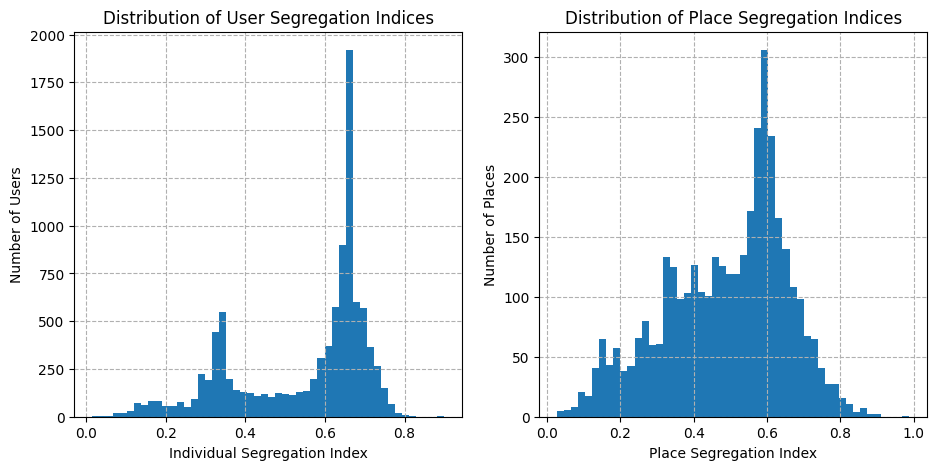

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 可视化结果
plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
plt.hist(user_segregation_df['composite_integration_index'], bins=50)
plt.xlabel('Individual Segregation Index')
plt.ylabel('Number of Users')
plt.title('Distribution of User Segregation Indices')
plt.grid(True, linestyle="--")

# 可视化地点隔离指数的分布
plt.subplot(1, 2, 2)
plt.hist(place_segregation_df['composite_integration_index'], bins=50)
plt.xlabel('Place Segregation Index')
plt.ylabel('Number of Places')
plt.title('Distribution of Place Segregation Indices')
plt.grid(True, linestyle="--")

plt.show()

## 隔离统计

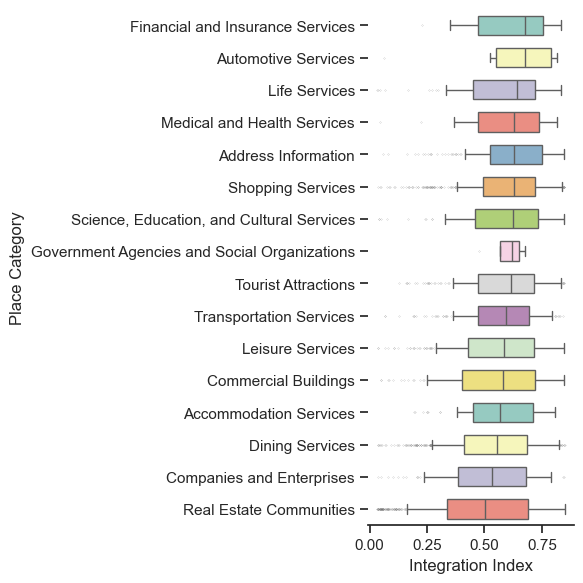

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 

sns.set_theme(style="ticks")
palette = sns.color_palette('Set3')

df = pd.read_csv(r'D:\Coding\segaration_research\place_segregation_and_connection.csv', encoding='utf-8')

# var= 'composite_integration_index'
var= 'integration_index'

# df = df[df[var].ne(0) & df[var].ne(1)]
q_low = df[var].quantile(0.05)
q_hi = df[var].quantile(0.95)
df_clean = df[(df[var] > q_low) & (df[var] < q_hi)]

# 计算每个标签的中位数，并按中位数从大到小排序
median_values = (
    df_clean.groupby("category")[var]
    .median()
    .reset_index()
    .sort_values(by=var, ascending=False)
)

# 将原数据框中的标签列转化为有序类别，按中位数排序
df_clean["category"] = pd.Categorical(
    df_clean["category"], 
    categories=median_values["category"], 
    ordered=True
)

# 按标签排序数据框
filtered_df_sorted = df_clean.sort_values(by="category")

g = sns.catplot(
    data=filtered_df_sorted, 
    kind='box',
    x=var, 
    y="category",  
    errorbar="ci", 
    # alpha=.8,
    height=6, 
    aspect=1,
    palette=palette,
    width=0.6,
    whis=0.5,
    fliersize=0.1
)
plt.ylabel('Place Category', fontsize=12)
plt.xlabel('Integration Index', fontsize=12)
g.despine(left=True)
# plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig5.jpg", dpi=600, bbox_inches='tight')

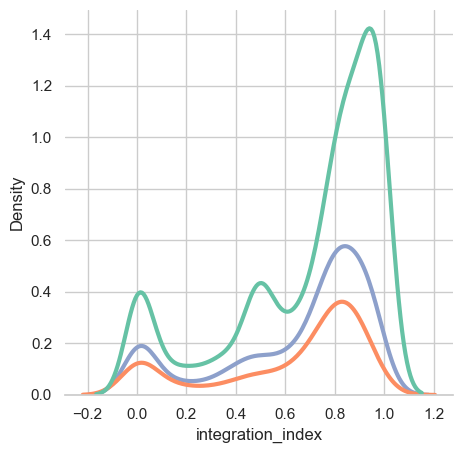

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
palette = sns.color_palette('Set2')

# 读取 CSV 数据
df = pd.read_csv(r'D:\Coding\segaration_research\user_segregation_indices.csv', encoding='utf-8')

# 过滤数据
vars = 'composite_integration_index'
q_low = df[vars].quantile(0.05)
q_hi = df[vars].quantile(0.95)
df_clean = df[(df[vars] > q_low) & (df[vars] < q_hi)]

# 使用 Seaborn 的 kdeplot 函数绘制 KDE 图
plt.figure(figsize=(5, 5))
g = sns.kdeplot(data=df_clean, 
            x='integration_index', 
            hue='SES', 
            fill=False,
            palette=palette,
            alpha=1,
            legend=False,
            linewidth=3,
            )

# 去掉所有边框
# g.legend(frameon=False)
g.spines['top'].set_visible(False)
g.spines['left'].set_visible(False)
g.spines['right'].set_visible(False)
# plt.xlabel('Different Gender Experience Diversity', fontsize=16)
# plt.ylabel('Density', fontsize=16)
# 调整图例的位置
# g.legend(title='Age Label', loc='upper left')
# plt.savefig("D:/研究生/03Phd/segregation/figure/Density_gender.jpg", dpi=600, bbox_inches='tight')
plt.show()

<Figure size 500x500 with 0 Axes>

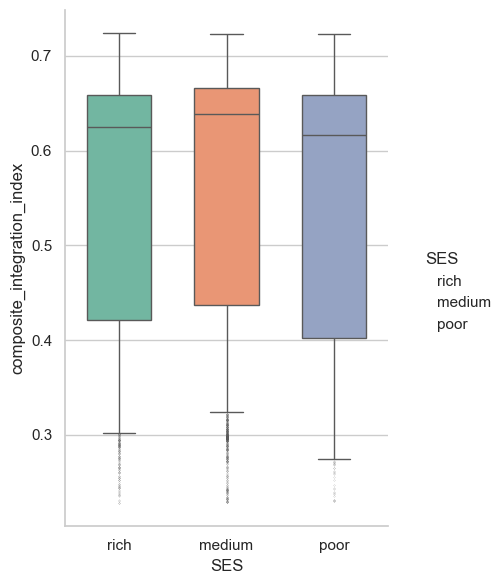

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
palette = sns.color_palette('Set2')

# 读取 CSV 数据
df = pd.read_csv(r'D:\Coding\segaration_research\user_segregation_indices.csv', encoding='utf-8')

# 过滤数据
vars = 'composite_integration_index'
q_low = df[vars].quantile(0.05)
q_hi = df[vars].quantile(0.95)
df_clean = df[(df[vars] > q_low) & (df[vars] < q_hi)]

category_order = ['rich', 'medium', 'poor']
df_clean['SES'] = pd.Categorical(df_clean['SES'], categories=category_order, ordered=True)

plt.figure(figsize=(5, 5))
g = sns.catplot(
    data=df_clean, 
    kind='box',
    x="SES", 
    y="composite_integration_index",  
    errorbar="ci", 
    # alpha=.8,
    height=6, 
    aspect=0.7,
    palette=palette,
    width=0.6,
    whis=0.5,
    fliersize=0.1,
    legend=True,
)

# plt.xlabel('Different Gender Experience Diversity', fontsize=16)
# plt.ylabel('Density', fontsize=16)
# 调整图例的位置
# g.legend(title='Age Label', loc='upper left')
# plt.savefig("D:/研究生/03Phd/segregation/figure/Density_gender.jpg", dpi=600, bbox_inches='tight')
plt.show()

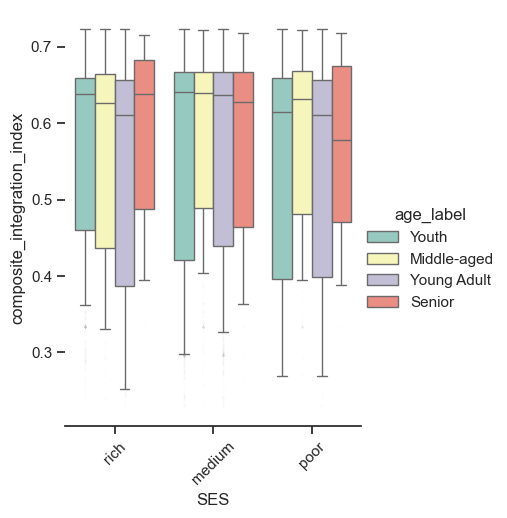

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取 CSV 数据
df = pd.read_csv(r'D:\Coding\segaration_research\user_segregation_indices.csv', encoding='utf-8')

# 过滤数据
vars = 'composite_integration_index'
q_low = df[vars].quantile(0.05)
q_hi = df[vars].quantile(0.95)
df_clean = df[(df[vars] > q_low) & (df[vars] < q_hi)]

# 设置类别顺序
category_order = ['rich', 'medium', 'poor']
df_clean['SES'] = pd.Categorical(df_clean['SES'], categories=category_order, ordered=True)

# 绘图
sns.set_theme(style="ticks")
palette = sns.color_palette('Set3')
# custom_palette = [palette[4], palette[0]]  # 选择不同的颜色，例如第2和第3个颜色

g = sns.catplot(
    data=df_clean, 
    kind='box',
    x="SES", 
    y=vars,  
    hue="age_label",  # 添加这行来根据性别着色
    errorbar="ci", 
    height=5,
    aspect=0.8,
    palette=palette,
    width=0.8,
    whis=0.5,
    fliersize=0.01,
    legend=True  # 去掉图例
)

# 设置轴标签和旋转 x 轴标签
# plt.xlabel('Economics Levels', fontsize=12)
# plt.ylabel('Experience Exposure to Poor', fontsize=12)
g.set_xticklabels(rotation=45)

# 去除左边框线
g.despine(left=True)

# 保存图像
# plt.savefig("./EEI_POOR2.jpg", dpi=600, bbox_inches='tight')

plt.show()

In [21]:
from scipy import stats

def anova_test(df, group_col, value_col):
    groups = df[group_col].unique()
    data = [df[df[group_col] == group][value_col] for group in groups]
    f_value, p_value = stats.f_oneway(*data)
    return f_value, p_value

# 使用示例（以性别为例）
f_value, p_value = anova_test(user_segregation_df, 'age_label', 'composite_integration_index')
print(f"ANOVA结果：F值 = {f_value:.4f}, p值 = {p_value:.4f}")

f_value, p_value = anova_test(user_segregation_df, 'SES', 'composite_integration_index')
print(f"ANOVA结果：F值 = {f_value:.4f}, p值 = {p_value:.4f}")

f_value, p_value = anova_test(user_segregation_df, 'gender', 'composite_integration_index')
print(f"ANOVA结果：F值 = {f_value:.4f}, p值 = {p_value:.4f}")

f_value, p_value = anova_test(place_segregation_df, 'category', 'composite_integration_index')
print(f"ANOVA结果：F值 = {f_value:.4f}, p值 = {p_value:.4f}")

ANOVA结果：F值 = 5.9040, p值 = 0.0005
ANOVA结果：F值 = 1.3611, p值 = 0.2564
ANOVA结果：F值 = 11.1235, p值 = 0.0009
ANOVA结果：F值 = 19.9770, p值 = 0.0000
